##  Capstone Project - The Battle of the Neighborhoods
#### Applied Data Science Capstone by IBM/Coursera
Helsinki (Finland) vs. Tallinn (Estonia)
Prepared by:  Norbert Juhász

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Analysis](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)


## Introduction / Business Problem <a name="introduction"></a>

In this final course assignment, I will compare neighborhoods of two cities: Helsinki, Finland (where I live) and Tallinn, Estonia (which is the closest other EU capital, just on the other side of the Gulf of Finland). There are even plans to connect the two cities by an underwater tunnel in the future. For more about this, please see https://en.wikipedia.org/wiki/Helsinki%E2%80%93Tallinn_Tunnel

Understanding the similarities of neighbourhoods between the two cities may help people who consider moving from one city to the other. For someone who, for instance, was looking for a similar neighborhood to live in Tallinn as compared to where they live in Helsinki, the results of my analysis may be helpful.

In this project assignment, the neighborhoods of the two cities will be clustered, analyzed and described.

## Data <a name="data"></a>

Based on definition of my analysis, the primary interest is profiling the neighourhoods of Helsinki and Tallinn with the purpose to cluster them based on their similarities.

The following data sources will be used:
* the neighborhoods of Helsinki and Tallinn are defined based on postal codes from **Opendatasoft.com**'s API
     * dataset name: "geonames-postal-code%40public-us"
     * data of interest: postal code, neighborhood name, latitude, longitude, administrative structure of 4 levels
     * **Helsinki** is defined as Greater Helsinki area, including the administrative (but not geographically) separate cities of Espoo, Kauniainen and Vantaa
     * **Tallinn** city is extended by the region of Viimsi vald which encompasses Tallinn towards the direction of Helsinki
* the central coordinates of Helsinki and Tallinn were retrieved from **geocoders Nominatim**
     * in order to center the map to make both cities are visible, the coordinates of the two cities are averaged
* the venues, their type and location in every neighborhood will be obtained from the **Foursquare API** (as required by the assignment specifications)

In [14]:
# ! pip install pandas
import pandas as pd
import numpy as np
# !pip install requests
import requests
import json 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
! pip install geopy
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
! pip install folium
import folium
import seaborn as sns
%matplotlib inline

### Postal codes
Preparing the function which connects to the Opendatasoft API to load the list of postal codes for Finland and Estonia.

In [15]:
def loadPostalCodeData_Country(country_code, rows=10000):
    results_appended=[]
    for country_code in country_code_list:
        url = 'https://data.opendatasoft.com/api/records/1.0/search/?dataset=geonames-postal-code%40public-us&rows={}&facet=country_code&refine.country_code={}'.format(
            rows,
            country_code)
        results = requests.get(url).json()
        results_n = json_normalize(results['records'])
        results_appended.append(results_n) 
    results_appended = pd.concat(results_appended,sort=True)
    # FULL LIST: 'datasetid','fields.accuracy','fields.admin_code1','fields.admin_code2','fields.admin_code3','fields.admin_name1',
    # 'fields.admin_name2','fields.admin_name3','fields.coordinates','fields.country_code','fields.latitude','fields.longitude',
    # 'fields.place_name','fields.postal_code','geometry.coordinates','geometry.type','record_timestamp','recordid'
    postal_codes = results_appended[['fields.postal_code','fields.place_name','fields.latitude','fields.longitude',
                                     'fields.admin_name3','fields.admin_name2','fields.admin_name1','fields.country_code']]
    postal_codes.columns = postal_codes.columns.map(lambda x: x.rsplit('.', 1)[1])
    return postal_codes

The function was made so that it can loop through a given list. In the scope of this assignment, FI and EE are relevant.

In [16]:
country_code_list = ['FI','EE'] # Finland and Estonia
postal_codes = loadPostalCodeData_Country(country_code_list)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [17]:
# Administrative level 3 (admin_name3) is replaced by 'Not assigned' in case if null
postal_codes['admin_name3'] = postal_codes['admin_name3'].fillna('Not assigned')

In [18]:
postal_codes['latitude'] = postal_codes['latitude'].astype('float')
postal_codes['longitude'] = postal_codes['longitude'].astype('float')
postal_codes.dtypes

postal_code      object
place_name       object
latitude        float64
longitude       float64
admin_name3      object
admin_name2      object
admin_name1      object
country_code     object
dtype: object

Scoping is necessary to keep only those postal code that define the Greater Helsinki and Tallinn regions.

In [19]:
# capreg = capital regions
postal_codes_capreg = postal_codes[postal_codes['admin_name3'].isin(['Helsinki','Espoo','Kauniainen','Vantaa'])] #Finland
postal_codes_capreg = postal_codes_capreg.append(postal_codes[postal_codes['admin_name2'].isin(['Tallinn','Viimsi vald'])]) #Estonia
postal_codes_capreg.reset_index(inplace=True,drop=True)
postal_codes_capreg.groupby(by=['country_code','admin_name1','admin_name2']).count()

postal_code  place_name  latitude  \
country_code admin_name1   admin_name2                                      
EE           Harju maakond Tallinn              291         291       291   
                           Viimsi vald           19          19        19   
FI           Uusimaa       Helsinki             169         169       169   

                                        longitude  admin_name3  
country_code admin_name1   admin_name2                          
EE           Harju maakond Tallinn            291          291  
                           Viimsi vald         19           19  
FI           Uusimaa       Helsinki           169          169

The loaded postal code data from Opendatasoft API has yielded 169 postal codes for the Helsinki capital region and 310 postal codes for Tallinn. Based on the population of the two cities (about 1.2 million for Helsinki and about 450 thousand for Tallinn), the expectation was to find more postal codes for Helsinki. However, clarifying the administrative differences between the two countries is out of scope from this project. 

In [20]:
## For IBM Watson (save csv)
# from project_lib import Project
# project = Project.access("e0c0b4aa-9524-47d4-bf94-50bf5796fe67","p-0c3994a4754a851e21bc13aa94ffeda4cd7066c9")
# project.save_data(file_name = "Postal_Codes_Helsinki_Tallinn.csv",data = postal_codes_capreg.to_csv(index=False),overwrite=True)
# project.save_data(file_name = "Postal_Codes_FI_EE.csv",data = postal_codes.to_csv(index=False,overwrite=True))

## For IBM Skills Network Lab (save csv)
# postal_codes_capreg.to_csv('Postal_Codes_Helsinki_Tallinn.csv')

In [21]:
postal_codes_capreg.head()

,postal_code,place_name,latitude,longitude,admin_name3,admin_name2,admin_name1,country_code
0,00340,Helsinki,60.1819,24.8594,Helsinki,Helsinki,Uusimaa,FI
1,00380,Helsinki,60.2173,24.8722,Helsinki,Helsinki,Uusimaa,FI
2,00430,Helsinki,60.2501,24.8962,Helsinki,Helsinki,Uusimaa,FI
3,00570,Helsinki,60.1838,25.0055,Helsinki,Helsinki,Uusimaa,FI
4,00800,Helsinki,60.2082,25.0404,Helsinki,Helsinki,Uusimaa,FI


### Map of Helsinki and Tallinn neighborhoods
Loading the coordinates of Helsinki and Tallinn --> averaging them out to center the map in such a way that both cities are visible --> marking the neighourhoods

In [22]:
# location.latitude & location.longitude
geolocator = Nominatim(user_agent="ny_explorer")
loc_FI_Hel = geolocator.geocode('Helsinki, Finland')
loc_EE_Tal = geolocator.geocode('Tallinn, Estonia')
loc_Heltal = (np.average((loc_FI_Hel.latitude, loc_EE_Tal.latitude)), np.average((loc_FI_Hel.longitude, loc_EE_Tal.longitude)))

In [23]:
map_heltal = folium.Map(location=loc_Heltal, zoom_start=8, width='70%', height='100%')
for lat, lng, borough, neighborhood in zip(postal_codes_capreg['latitude'], postal_codes_capreg['longitude'], postal_codes_capreg['postal_code'], postal_codes_capreg['place_name']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_heltal)  
map_heltal

### Foursquare location data
Loading the Foursquare venue location category data --> Analyzing the data from an exploratory angle --> Processing the data for clustering

Preparing the function (based on the lecture) which connects to the Foursquare API to load the location venue data.

In [24]:
CLIENT_ID = '*****' # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=900, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [ ]:
# loading the data
venues_heltal = getNearbyVenues(names=postal_codes_capreg['postal_code'], latitudes=postal_codes_capreg['latitude'], longitudes=postal_codes_capreg['longitude'])

In [26]:
## For IBM Watson (save/read csv)
# as the Foursquare API has daily limits, this cell reads and writes the retrieved data to csv onto the IBM Watson storage
# below codes are unquoted as needed
# project.save_data(file_name = "Venues_Helsinki_Tallinn3.csv",data = venues_heltal.to_csv(index=False))
# read_file = project.get_file("Venues_Helsinki_Tallinn2.csv")
# read_file.seek(0)
# venues_heltal = pd.read_csv(read_file)

## For IBM Skills Network Lab (save/read csv)
# venues_heltal.to_csv('Venues_Helsinki_Tallinn4.csv')
venues_heltal = pd.read_csv('Venues_Helsinki_Tallinn4.csv',dtype=object)

## Methodology and Analysis <a name="methodology"></a>

Firstly, the collected data is explored and visually analysed to ensure that it is suitable for the purpose.

The loaded location venue data has yielded 17 538 records. This is a result of a Foursquare API request to explore the radius of 900m from each postal code coordinate and to retrieve a list of the maximum 100 most popular venues for each of them.

In [27]:
# Checking the loaded location venue content, making some formatting adjustments and preparing it for exploratory analysis
print(venues_heltal.shape)
print('There are {} uniques categories.'.format(len(venues_heltal['Venue Category'].unique())))
venues_heltal.rename(columns={"Neighborhood": "postal_code", "Neighborhood Latitude": "latitude", "Neighborhood Longitude": "longitude"},inplace=True)
venues_heltal.drop("Unnamed: 0", axis=1, inplace=True)
venues_heltal['latitude'] = venues_heltal['latitude'].astype('float')
venues_heltal['longitude'] = venues_heltal['longitude'].astype('float')
venues_heltal['Venue Latitude'] = venues_heltal['Venue Latitude'].astype('float')
venues_heltal['Venue Longitude'] = venues_heltal['Venue Longitude'].astype('float')

(17538, 8)
There are 417 uniques categories.


In [29]:
#checking the venue list of a well-known neighbourhood
venues_heltal[venues_heltal['postal_code'] == '02600'].head()

,postal_code,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1069,02600,60.2122,24.8066,Mezza,60.215323,24.811755,Middle Eastern Restaurant
1070,02600,60.2122,24.8066,Jungle Juice Bar,60.218400,24.813196,Juice Bar
1071,02600,60.2122,24.8066,Caffi,60.218603,24.812755,Coffee Shop
1072,02600,60.2122,24.8066,Fressi,60.216913,24.818744,Gym / Fitness Center
1073,02600,60.2122,24.8066,ELIXIA Sello,60.218130,24.812810,Gym / Fitness Center


In [30]:
venues_heltal.dtypes

postal_code         object
latitude           float64
longitude          float64
Venue               object
Venue Latitude     float64
Venue Longitude    float64
Venue Category      object
dtype: object

In [31]:
# joining the two dataframes in order to bring the administrative division into the venue dataframe 
venues_heltal_capreg = pd.merge(venues_heltal, postal_codes_capreg, on=['postal_code', 'latitude','longitude'], how='left')

In [32]:
# changing the administrative levels to a more suitable structure for comparison
venues_heltal_capreg['admin_area'] = venues_heltal_capreg['admin_name2']
venues_heltal_capreg['admin_area'][venues_heltal_capreg['admin_name2'] == 'Helsinki'] = venues_heltal_capreg['admin_name3']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
venues_heltal_capreg.drop(['admin_name3','admin_name2','admin_name1'], axis=1, inplace=True)

In [34]:
venues_heltal_capreg.head()

,postal_code,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,place_name,country_code,admin_area
0,00340,60.1819,24.8594,Didrichsenin taidemuseo,60.185164,24.856647,Art Museum,Helsinki,FI,Helsinki
1,00340,60.1819,24.8594,Old Jerusalem,60.180725,24.850076,Falafel Restaurant,Helsinki,FI,Helsinki
2,00340,60.1819,24.8594,Villa Gyllenberg,60.183908,24.852361,Art Gallery,Helsinki,FI,Helsinki
3,00340,60.1819,24.8594,Maja coffee roastery,60.180869,24.849945,Coffee Shop,Helsinki,FI,Helsinki
4,00340,60.1819,24.8594,Alepa,60.181390,24.850629,Grocery Store,Helsinki,FI,Helsinki


Performing some exploratory analysis on the merged and cleaned dataframe

In [35]:
venues_heltal_capreg.shape

(17538, 10)

In [36]:
venues_heltal_capreg_pivot = venues_heltal_capreg.pivot_table(values='Venue', index='Venue Category', columns=['country_code'], aggfunc='count')

The location venue data contains 417 unique venue categories. A Pareto analysis reveals that approximately 75-80 venue categories cover 80% of the total venue count. The Pareto curve is similar for both capital regions. It is also visible from the chart that there are unique categories for both Tallinn or Helsinki.

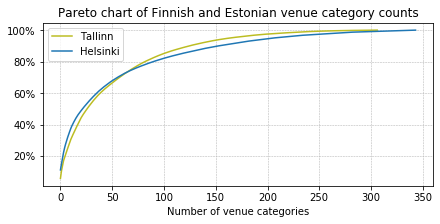

In [37]:
# preparing a Pareto chart on venue categories in Finland and Estonia
from matplotlib.ticker import PercentFormatter

df_fi = venues_heltal_capreg_pivot['FI'].sort_values(ascending=False).dropna().to_frame()
df_fi['FI_cum'] = df_fi['FI'].cumsum()/df_fi['FI'].sum()*100
df_fi.reset_index(inplace=True,drop=True)
df_ee = venues_heltal_capreg_pivot['EE'].sort_values(ascending=False).dropna().to_frame()
df_ee['EE_cum'] = df_ee['EE'].cumsum()/df_ee['EE'].sum()*100
df_ee.reset_index(inplace=True,drop=True)
df_fi_ee = pd.concat([df_fi, df_ee], axis=1)

fig, ax = plt.subplots(figsize = (7,3))
ax.plot(df_fi_ee.index, df_fi_ee["EE_cum"], color='C8')
ax.plot(df_fi_ee.index, df_fi_ee["FI_cum"], color="C0")
ax.legend(['Tallinn','Helsinki'])
ax.grid(linestyle='--', linewidth=0.5)
ax.set_title('Pareto chart of Finnish and Estonian venue category counts')
ax.set_xlabel('Number of venue categories')
ax.yaxis.set_major_formatter(PercentFormatter())

plt.show()

110 venue categories (26.4%) are unique for Helsinki and 73 venue categories are unique for Tallinn (17.5%). On the other side of the coin, 234 venue categories are shared between the two city regions (56.1%), representing a 90.5% share of the total venue count. The two cities have a different historical and cultural profile, which explains and justifies the prevalence of unique venue categories. Having this unique share is seen as giving a positive flair to the clustering algorithm. The overlapping share is large enough to allow clustering similar neighborhoods. 

In [38]:
# checking those venue categories that are unique for Helsinki
fi_unique = venues_heltal_capreg_pivot[venues_heltal_capreg_pivot['EE'].isnull()].sort_values('FI',ascending=False)
print(fi_unique)
print("Total venues in unique Finnish venue categories: {}".format(int(fi_unique['FI'].sum())))

country_code                     EE    FI
Venue Category                           
Himalayan Restaurant            NaN  38.0
Waterfront                      NaN  17.0
Taxi Stand                      NaN  17.0
Platform                        NaN  15.0
Karaoke Bar                     NaN  13.0
...                              ..   ...
Molecular Gastronomy Restaurant NaN   1.0
Outdoor Gym                     NaN   1.0
Canal Lock                      NaN   1.0
Carpet Store                    NaN   1.0
Road                            NaN   1.0

[110 rows x 2 columns]
Total venues in unique Finnish venue categories: 406


In [39]:
# checking those venue categories that are unique for Tallinn
ee_unique = venues_heltal_capreg_pivot[venues_heltal_capreg_pivot['FI'].isnull()].sort_values('EE',ascending=False)
print(ee_unique)
print("Total venues in unique Estonian venue categories: {}".format(int(ee_unique['EE'].sum())))

country_code                                 EE  FI
Venue Category                                     
Eastern European Restaurant               258.0 NaN
Bus Line                                  111.0 NaN
Market                                     59.0 NaN
Church                                     55.0 NaN
Shoe Store                                 53.0 NaN
...                                         ...  ..
Ski Chairlift                               1.0 NaN
Residential Building (Apartment / Condo)    1.0 NaN
Fruit & Vegetable Store                     1.0 NaN
Animal Shelter                              1.0 NaN
Veterinarian                                1.0 NaN

[73 rows x 2 columns]
Total venues in unique Estonian venue categories: 1265


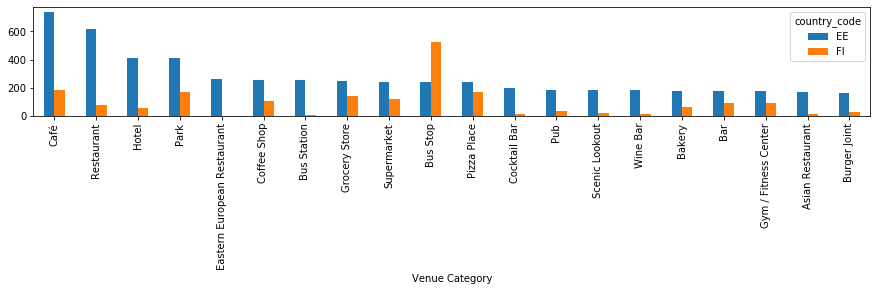

In [40]:
# Top 25 locations of Estonia vs. Finland
venues_heltal_capreg_pivot.sort_values('EE',ascending=False).head(20).plot(kind='bar',figsize=(15,2))

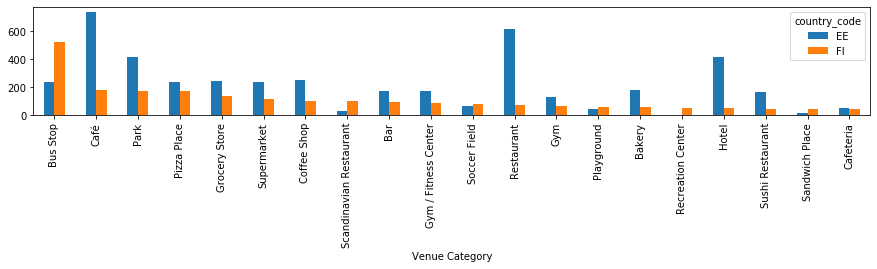

In [41]:
# Top 25 locations of Finland vs. Estonia
venues_heltal_capreg_pivot.sort_values('FI',ascending=False).head(20).plot(kind='bar',figsize=(15,2))

### The battle of neighborhoods (clustering)
Using the kMeans clustering algorhithm to cluster the neighborhoods of Helsinki capital region and Tallinn

In [42]:
# one hot encoding
venues_heltal_onehot = pd.get_dummies(venues_heltal[['Venue Category']], prefix="", prefix_sep="")
venues_heltal_onehot['postal_code'] = venues_heltal['postal_code']
venues_heltal_onehot['latitude'] = venues_heltal['latitude']
venues_heltal_onehot['latitude'] = venues_heltal_onehot['latitude'].astype('object')
venues_heltal_onehot['longitude'] = venues_heltal['longitude']
venues_heltal_onehot['longitude'] = venues_heltal_onehot['longitude'].astype('object')
fixed_columns = list(venues_heltal_onehot.columns[-3:]) + list(venues_heltal_onehot.columns[:-3]) # move neighborhood column to the first column
venues_heltal_onehot = venues_heltal_onehot[fixed_columns]
venues_heltal_grouped = venues_heltal_onehot.groupby(['postal_code','latitude','longitude']).mean().reset_index()
venues_heltal_grouped.shape

(479, 420)

In [43]:
venues_heltal_grouped_clustering = venues_heltal_grouped.drop(['postal_code','latitude','longitude'], 1)

Ks = 15
X_dist = np.zeros((Ks-1))
for n in range(1,Ks):
    kmeans = KMeans(n_clusters=n, random_state=4).fit(venues_heltal_grouped_clustering)
    X_dist[n-1] = kmeans.inertia_

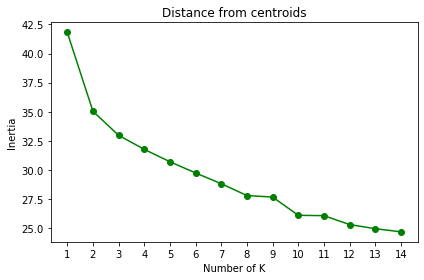

In [44]:
plt.plot(range(1,Ks),X_dist,'g',marker='o')
plt.figsize=(10,5)
plt.title(('Distance from centroids'))
plt.ylabel('Inertia')
plt.xlabel('Number of K')
plt.xticks(range(1,Ks,1))
plt.tight_layout()
plt.show()

Selecting 8 clusters as k (2 was checked but it was found not useful) -> running the model -> describing the clusters 

## Results <a name="results"></a>

The components of the results and discussion session are distributed below.

In [45]:
k_selected = 8
kmeans = KMeans(n_clusters=k_selected, random_state=4).fit(venues_heltal_grouped_clustering)

In [46]:
# add clustering labels
venues_heltal_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
venues_heltal_grouped.head()

,Cluster Labels,postal_code,latitude,longitude,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Lounge,...,Volleyball Court,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,2,00100,60.1714,24.9316,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.02,0.01,0.0,0.0,0.01,0.0
1,2,00120,60.1632,24.9391,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.03,0.00,0.0,0.0,0.02,0.0
2,2,00130,60.1645,24.9487,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.01,0.01,0.0,0.0,0.02,0.0
3,2,00140,60.1578,24.9525,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.01,0.00,0.0,0.0,0.00,0.0
4,2,00150,60.1570,24.9369,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.01,0.00,0.0,0.0,0.01,0.0


In [47]:
clusters_heltal = venues_heltal_grouped.drop(['Neighborhood','latitude','longitude'], 1).groupby(by=['Cluster Labels']).mean()
clusters_heltal_unstacked = clusters_heltal.stack().reset_index()
clusters_heltal_unstacked.columns = ['Cluster Labels', 'Venue Category', 'Freq']
clusters_heltal_unstacked.dtypes

Cluster Labels      int64
Venue Category     object
Freq              float64
dtype: object

Cluster 0 appears only in Helsinki (red colour on the map). It seems to represent such neighborhoods where having a bus stop is a critical (and popular) part of the profile. This cluster also exhibits venue categories that represent sport and smaller smaller shops to buy food.

Cluster 1 is a small cluster overlapping both cities (purple on the map). In both cities, it represents neighorhoods close to mostly the seashore, but also to nature and historical sites.

Cluster 2 clearly describes the city centres (purple on the map) and a few other central neighborhoods in other parts of the cities. This is one of the biggest clusters and it is mainly described by the prevalence of popular venues, such as cafés, restaurants, parks, hotels, bars etc. 

Cluster 3 is the smallest cluster made up of only one postal code in Helsinki (light blue on maps), one construction & landscaping venue in the northern part of the city.

Cluster 4 is a cluster with many postal codes widespread all over Helsinki, but only a small number of postal codes in Tallinn in the
south of the city (cyan on maps). This cluster profile looks similar to Cluster 0, but the frequency of having a bus stop as a top venue is not as large as in Cluster 0. This cluster would thus represent those nature intensive parts that still have a good access to supermarkets, cafés etc. This can be also confirmed by own experience with having lived in such regions.

Cluster 5 seems to be yet an additional step away from Cluster 0 and Cluster 4 (light green on maps). The popularity of having a bus stop further decreases and the importance of other categories increases. This cluster is well represented in both cities and it often borders Cluster 2 (city centre). In Helsinki, forest areas are widespread and are easily reachable from basically anywhere. This is not similar in Tallinn, so it can explain the shift of cluster count between the cities.

Cluster 6 is also represented in both cities (light orange on maps), but much more widespread in Tallinn. Large parts of the Tallinn outer neighborhoods belong to this cluster, whereas in Helsinki only a small number does (but also in the outer parts of the city though). This cluster is more intensive in frequent access to food places and stores to buy food. 

Cluster 7 is a middle sized cluster appearing only in Tallinn (dark orange on the map) and there mostly on the most southern side.
It this cluster, access to public transportation is also prominent, but the rest of the venue categories a show different profile ratio.

In [48]:
num_top_venues = 10

for cluster_label in clusters_heltal_unstacked['Cluster Labels'].unique():
    print("----"+str(cluster_label)+"----")
    temp = clusters_heltal_unstacked[clusters_heltal_unstacked['Cluster Labels'] == cluster_label].reset_index(drop=True)
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
   Cluster Labels        Venue Category      Freq
0               0              Bus Stop  0.510887
1               0         Grocery Store  0.067734
2               0           Pizza Place  0.058091
3               0                 Beach  0.019928
4               0          Soccer Field  0.018711
5               0            Playground  0.017475
6               0  Gym / Fitness Center  0.015259
7               0                  Park  0.014612
8               0     Convenience Store  0.013686
9               0                 Trail  0.011702


----1----
   Cluster Labels   Venue Category      Freq
0               1            Beach  0.254762
1               1    Historic Site  0.107143
2               1  Harbor / Marina  0.079762
3               1    Boat or Ferry  0.053571
4               1              Bar  0.047619
5               1   History Museum  0.035714
6               1       Food Court  0.032143
7               1       Playground  0.026190
8               1      

In [49]:
venues_heltal_capreg_joined = pd.merge(venues_heltal_grouped, postal_codes_capreg, on=['postal_code', 'latitude','longitude'], how='left')

In [50]:
# checking that there are no Null clusters
venues_heltal_capreg_joined['Cluster Labels'].value_counts(dropna=False)

2    164
6    100
5     79
4     65
7     33
0     23
1     14
3      1
Name: Cluster Labels, dtype: int64

The k-Mean algorhitm has identified 7 clusters for Helsinki and 6 for Tallinn. There are only 5 clusters that overlap the two cities, with 2 clusters being unique for Helsinki and 1 for Tallinn.

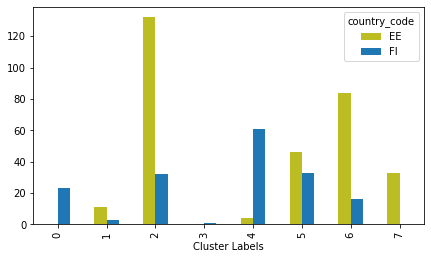

In [51]:
# checking how many postal codes belong to each cluster in both countries
cluster_count_pivot = venues_heltal_capreg_joined.pivot_table(values='postal_code', index='Cluster Labels', columns=['country_code'], aggfunc='count')
cluster_count_pivot.plot(kind='bar', figsize=(7,4), color=['C8','C0'])

In [52]:
# finally, mapping the clusters
map_heltal_cluster = folium.Map(location=loc_Heltal, zoom_start=9, width='100%', height='100%')

kclusters = k_selected
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, poi, cluster in zip(venues_heltal_capreg_joined['latitude'], venues_heltal_capreg_joined['longitude'], venues_heltal_capreg_joined['postal_code'], venues_heltal_capreg_joined['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='black', weight='1', fill=True, fill_color=rainbow[cluster-1], fill_opacity=2).add_to(map_heltal_cluster)  
    
map_heltal_cluster

## Discussion <a name="discussion"></a>

The goal of this analysis has been to understanding the similarities of neighbourhoods between the Helsinki capital area and Tallinn in order to help people who consider moving from one city to the other. 

For this end, the results of the k-Means clustering algorhitms have returned useful points to consider:
-	Although the structural composition of the two cities is different, there are clear overlapping clusters:
        - The city centres and central locations of a few other city parts (cluster 2)
        - Neighborhoods with seashore and/or close to natural and historical sites (cluster 1, small)
-	Moving futher outside from the city centres towards the suburbs, it becomes visible that more distant neighborhoods start getting a more and more diverging character in Helsinki and Tallinn:
        - Often encompassing the city centres, Cluster 5 appears and is significant in size in both cities.
        - In Helsinki, Cluster 4 seems to be a continuation to Cluster 5, representing an increased profile weight of public transportation and a decreased profile weight of shopping and dining venues. In Tallinn, Cluster 4 appears too, but it is very small and is located on the southern outskirts.
        - Similarly to Cluster 4 described above, Cluster 6 seems to be a similar position, only from a mirrored point of view. This cluster is very large in Tallinn, but rather small in Helsinki.
        - One step further to the external areas from both Cluster 4 and Cluster 6, Cluster 0 is unique for Helsinki and Cluster 7 is unique for Tallinn. There are clear differences in the profile category weights, but both clusters strongly pronounce public transportation. In Tallinn, Cluster 7 is mostly concentrated in the south-western corner. In the Helsinki capital region, Cluster 0 also tends to be in more external locations, but because of the city is very forest-intensive, this cluster also appears in locations closer to the centre in between other cluster segments.
        
Reviewing the administrative differences between the two countries was left out of scope. Similarly, diving deeper into the definition of Foursquare venue categories and potentially regrouping some of them was not considered for this project. However, it was still observed (and it is also visible in this report above) that there are some differences between the prevalence of some categories between the two cities. For example:
-	There is a general ”Restaurant” category, strongly used in Helsinki but much less in Tallinn. On the other hand, there are quite many restaurant categories that come with type specification, such as ”Eastern European...” (unique for Tallinn) and ”Himalayan...” (unique for Helsinki). These are also restaurants, so it may be possible to group them together. Alternatively, it may be possible to identify the type of the restaurants from the general ”Restaurant” category. Both options may have advantages for the target group. Some people have strong preference for the type of restaurant, while others may not.
-	The key word ”bus” appears in multiple categories, such as ”Bus stop”, ”Bus station” and ”Bus line”. Some of these categories even appear in the same clusters. Although these are likely to have different physical properties, their purpose still connects to the importance of public transportation. It may thus be possible to group them, given assumptions about the target group is taken and accepted.

The above points may be relevant if someone would venture to continue this clustering work in the future. At this point, these stay only as observations to extends the outcome of the neighborhood clustering assignment.


## Conclusion <a name="conclusion"></a>

In this study, I analyzed the neighborhoods of the Helsinki capital region and Tallinn from the perspective of their  top venue category profiles. I identified 8 clusters in total (practically speaking 7 clusters – as one was a remote cluster with a construction site). In this report, the clusters were described and shown on the maps of both cities. The Results and Discussion parts contain many points that may help those people who consider moving from one city to another and seek a neighborhood with a similar (or different) profile. 